# About
A Python language replication of some **multivariate lognormal** analysis by Nassim Taleb. 

The original blog post is [here](https://fooledbyrandomnessdotcom.wordpress.com/2021/01/16/on-the-multivariate-lognormal-with-application-to-blood-pressure/). Twitter conversation [here](https://twitter.com/nntaleb/status/1350347801453068288)

### Jargon
* systolic pressure  := maximum pressure during one heartbeat
* diastolic pressure := minimum pressure between two heartbeats

### Dataset
Datasource: https://www.kaggle.com/amanajmera1/framingham-heart-study-dataset. 

To do this at home you need to: Create a kaggle account, download, open in excel and copy to clipboard.

In [1]:
from math import e, log, pi

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd

# Prepare Data

In [2]:
# Read the data from your clipboard (Ctrl+C in Excel)
raw_df = pd.read_clipboard()
raw_df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
# Select Columns of interest
df = raw_df.loc[:,['sysBP','diaBP']]

In [4]:
# Count rows in the data
len(df)

4240

In [5]:
# Show Summary Data
df.describe().loc[['mean','std'],:]

,sysBP,diaBP
mean,132.354599,82.897759
std,22.033300,11.910394


# Calibrate the Parameters

As per the blog's workings, we fit a multivariate lognormal to the data. We calibrate parameters by translating into normal distribution space. While in normal distribution space we calculate the sample metrics.

In [6]:
# Get Underlying Normal Distribution
ndf = df.copy()
ndf['sysBP']=df.sysBP.apply(log)
ndf['diaBP']=df.diaBP.apply(log)
ndf.head()

,sysBP,diaBP
0,4.663439,4.248495
1,4.795791,4.394449
2,4.848116,4.382027
3,5.010635,4.553877
4,4.867534,4.430817


We calculate parameters from the sample data.

In [7]:
# Calculate mean and standard deviation
params = ndf.describe().loc[['mean','std'],:]
params

,sysBP,diaBP
mean,4.872668,4.407611
std,0.157586,0.140755


In [8]:
# Assign the calibrated parameters to variables
mu1 = params.loc['mean','sysBP']
mu2 = params.loc['mean','diaBP']
sigma1 = params.loc['std','sysBP']
sigma2 = params.loc['std','diaBP']

In [9]:
# Calculate Correlation
rho = ndf.sysBP.corr(ndf.diaBP)
rho

0.7814043062526628

# Plot Multivariate Lognormal

##### Function definition

In [10]:
# Define the Multivariate Lognormal
def multivariate_lognormal_pdf(x1, x2, mu1, mu2, sigma1, sigma2, rho):
    """Probability density of a multivariate lognormal
    
    Parameters:
        x:     value
        mu:    mean of the underlying normal distribution
        sigma: standard deviation of the underlying normal distribution
        rho:   correlation between x1 and x2 underlying normal distributions"""
    
    # First we calculate the numerator
    top = -2*rho*sigma1*sigma2*(log(x1)-mu1)*(log(x2)-mu2)  +  (sigma1**2)*(log(x2)-mu2)**2 + (sigma2**2)*(log(x1)-mu1)**2
    bottom = 2*(rho**2-1)*sigma1**2*sigma2**2
    numerator = e**(top/bottom)
    
    # Next we calculate the denominator
    denominator = 2*pi*x1*x2*np.sqrt(-((rho**2-1)*sigma1**2*sigma2**2))
    
    probability_density = numerator/denominator
    
    return probability_density

In [11]:
# Check that the function executes without failing:
multivariate_lognormal_pdf(0.5,0.5,0,0,1,1,0)

0.39375132679587416

In [12]:
# Another Check
multivariate_lognormal_pdf(132, 82, mu1, mu2, sigma1, sigma2, rho)

0.0010557647746144685

In [13]:
# Freeze the calibrated parameters in place
calibrated_lognormal_pdf = lambda x1, x2: multivariate_lognormal_pdf(x1, x2, mu1, mu2, sigma1, sigma2, rho)

##### Generate the Surface Points

In [14]:
# Generate X and Y Values
systolic_range = np.linspace(80,180) # Flip so the plot layout is what we want later
diastolic_range = np.linspace(50,110)
X, Y = np.meshgrid(systolic_range, diastolic_range)

In [15]:
# Calculate Z, the Probability Densities
vfunc = np.vectorize(calibrated_lognormal_pdf)
Z = vfunc(systolic_range[:, np.newaxis], diastolic_range)

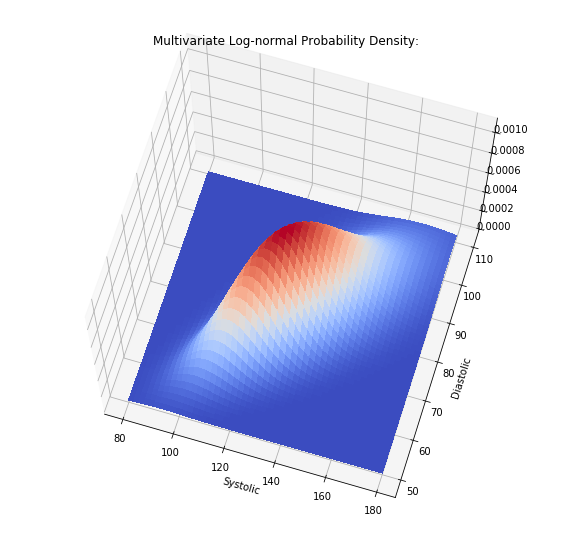

In [16]:
# Plot Multivariate Log-normal PDF
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')

ax.elev = 70 # Rotate Angle around x axis
ax.azim = -73 # Rotate angle around z axis


surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# The x and y labelling flips here
ax.set_ylabel('Diastolic')
ax.set_xlabel('Systolic')

plt.title('Multivariate Log-normal Probability Density:')
plt.show()